# Compositional Type Schema

This tutorial explore the Compositional Type Schema (CTS) for the Bigraph Interface Protocol. CTS enables different simulators, models, and data to communicate with each other through standardized type definitions and wiring diagrams. By providing a robust type system and serializable data format, CTS makes composite simulators shareable, extendable, and easily distributed across various computer architectures.

We'll use the [bigraph-schema](https://pypi.org/project/bigraph-schema/) library for validation and processing of the schema, and the [bigraph-viz](https://pypi.org/project/bigraph-viz/) library for plotting library for visualizing the resulting simulation configuration.

Bigraphs provide a powerful framework for compositional modeling due to their ability to represent complex systems through hierarchical structures and flexible reconfigurations, thus enabling the seamless composition and decomposition of system components. This notebook does not introduce the Bigraph concepts, rather it is focused on type definition and access. If you're new to the concepts of Bigraphs, check out the [Bigraph Schema Basics Tutorial](https://vivarium-collective.github.io/bigraph-viz/notebooks/basics.html).

### Installation
To start, let's install the necessary libraries and display their versions:

In [1]:
# !pip install bigraph-schema
# !pip install bigraph-viz
!pip freeze | grep bigraph

bigraph-schema==0.0.5
bigraph-viz==0.0.24


### Imports
We will use the `validate_schema` method to check our schemas, `fill` method to fill in missing details to prepare the schema for simulation, and the `type_registry` object to access different schemas and register new ones.

In [2]:
import copy
from bigraph_schema import (
    validate_schema, 
    validate_state, 
    fill, 
    type_registry
)
from bigraph_schema.registry import type_schema_keys  # Can't add to this because its a tuple
from bigraph_viz import plot_bigraph, pf, pp
from bigraph_viz.dict_utils import schema_keys

# register some required types
type_registry.register('URI', {'_default': '0-000-00000-0'})  # how do we test that something is a URI?
type_registry.register('KISAO', {'_default': 'KISAO:0000000'})  # how do we test that something is a URI?
schema_keys.append('_super') # TODO -- this should be default, also should use the bigraph_schema keys

## Type System
A type system comprises a set of rules and constraints that govern the organization, interaction, and manipulation of data types, facilitating efficient and error-free compositional modeling by guaranteeing compatibility and seamless communication between various components within a simulation.

Schemas serve as a formalized framework for defining and organizing types, providing explicit specifications for data representation, validation, and transformation. In a schema, types are characterized by specific `schema_keys` associated with type definitions, encompassing default values, serialization/deserialization methods, and additional metadata. The `schema_keys` encompass the following attributes:

In [3]:
type_schema_keys

('_default',
 '_apply',
 '_serialize',
 '_deserialize',
 '_type',
 '_value',
 '_divide',
 '_description',
 '_ports',
 '_type_parameters',
 '_super')

## Type Registry
A type registry is used to store and manage schema definitions related to various simulation modules, streamlining the process of accessing, extending, and reusing type information across different components. 

### List current types
The names of the current types available in the registry can be easily printed:

In [4]:
type_registry.list()

['string',
 'm/s',
 'shape',
 'int',
 'URI',
 'number',
 'rectangle',
 'edge',
 'list',
 'hash',
 'cube',
 '_',
 'float',
 'KISAO']

### Accessing a type
Types can be accessed from the registry by their name:

In [5]:
type_registry.access('float')

{'_apply': 'accumulate',
 '_serialize': 'str',
 '_description': '64-bit floating point precision number',
 '_default': '0.0',
 '_deserialize': 'float',
 '_divide': 'divide_float',
 '_super': ['number']}

### Expand a type to show all subtypes

In [6]:
pp(type_registry.expand('edge'))

{ 'wires': { '_type': 'hash',
             '_type_parameters': { 'A': { '_type': 'list',
                                          '_type_parameters': { 'A': { '_type': 'string'}}}}}}


### Register a new type
You can add new types to the type registry using  `type_registry.register(type_name:str, type_schema:dict)`:

In [7]:
sbml_schema = {
    '_super': 'string',
    'model_file': 'string',
    '_default': 'SBML:0000000',
    '_description': '',
}
type_registry.register(
    'SBML', sbml_schema)

## Processes

Processes are a type that includes a `_ports` key, which maps to a dictionary with `{port_name: port_type}`. Here is a 

In [8]:
from bigraph_schema.registry import deserialize_registry, serialize_registry, apply_registry

def protocol_location_serialize(value):
    return value

def protocol_location_deserialize(serialized_value):
    return serialize_value

def protocol_location_apply(existing_value, update):
    return update

serialize_registry.register('protocol:location', protocol_location_serialize)
deserialize_registry.register('protocol:location', protocol_location_deserialize)
apply_registry.register('protocol:location', protocol_location_apply)

protocol_location_schema = {
    '_default': ':',
    '_apply': '_',
    '_serialize': 'protocol:location',
    '_deserialize': 'protocol:location',
    '_description': 'a representation of how and where to access a process implementation',
}
type_registry.register(
    'protocol:location', protocol_location_schema)

#process schema
process_schema = {
    '_super': 'edge',
    'process_location': 'protocol:location',
    'config': 'hash[]',
    '_description': 'The base process schema.',
}
type_registry.register(
    'process', process_schema)

In [18]:
from vivarium.core.process import Process

class Test(Process):
    defaults = {}
    def __ini__(self, config):
        super().__init__(config)
    def ports_schema(self):
        return {
            'port': 'float'
        }
    def next_update(self, sync_step, state):
        return {
            'port': 0.0
        }
    

In [ ]:
process_state = {
    'test': {
        '_type': 'process',
        'process_location': '???'
        'config': {}
    }
}

In [10]:
temporal_process_schema = {
    '_super': 'edge',
    'process_location': 'URI',
    'config': {
        'update_method': 'KISAO',
        'model_file': 'SBML',
    },
    'sync_step': 'float',
    '_ports': {},
    '_description': '',
}
type_registry.register(
    'temporal_process', temporal_process_schema)

In [11]:
pp(type_registry.expand('temporal_process'))

{ '_description': '',
  '_ports': {},
  '_super': ['edge'],
  'config': { 'model_file': { '_apply': 'replace',
                              '_default': 'SBML:0000000',
                              '_description': '',
                              '_deserialize': 'str',
                              '_divide': 'divide_int',
                              '_serialize': 'str',
                              '_super': ['string'],
                              'model_file': { '_apply': 'replace',
                                              '_default': '',
                                              '_description': '64-bit integer',
                                              '_deserialize': 'str',
                                              '_divide': 'divide_int',
                                              '_serialize': 'str'}},
              'update_method': {'_default': 'KISAO:0000000'}},
  'process_location': {'_default': '0-000-00000-0'},
  'sync_step': { '_apply': 'accumula

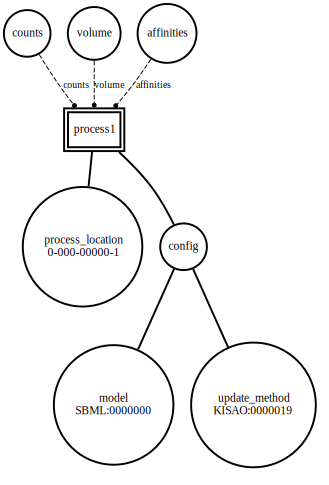

In [12]:
process_instance = {
    'process1': {
       'process_location': '0-000-00000-1',
       'config': {
           'model': 'SBML:0000000', 
           'update_method': 'KISAO:0000019',
       },
       'wires': {
            'counts': ['counts'],
            'volume': ['volume'],
            'affinities': ['affinities'],
        }
    }
}
plot_bigraph(process_instance, show_values=True)

## State
A state is the particular set of values that populate a bigraph structure, adhering to a predefined schema. The state is essential for understanding a system's behavior, as it encapsulates the current conditions and predicts future evolution based on the governing equations or rules. As the system evolves over time, the state transitions through various bigraphical configurations.

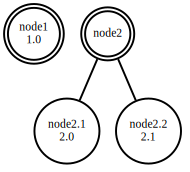

In [13]:
bigraph_state = {
    'node1': 1.0,
    'node2': {
        'node2.1': 2.0,
        'node2.2': 2.1
    }
}
plot_bigraph(bigraph_state, show_values=True)

### Fill state

One of the key advantages of a type system is its ability to improve automation in compositional modeling. The `fill` function exemplifies this by automatically populating missing schema elements. Given a schema and an incomplete instance, the fill function intelligently identifies and fills the missing schema components, ensuring that the instance is compliant with the schema definition.

In [14]:
dual_process_schema = {
    'process1': {
        '_ports': {
            'port1': 'float',
            'port2': 'int',
        },
    },
    'process2': {
        '_ports': {
            'port1': 'float',
            'port2': 'int',
        },
    },
}    

type_registry.register(
    'dual_process',
    dual_process_schema,
)

schema = {
    'store1': 'dual_process',
    'process3': {
        '_ports': {
            'port1': 'dual_process'
        }
    }
}

instance = {
    'store1': {
        'process1': {
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        },
        'process2': {
            'wires': {
                'port1': 'store1.1',
                'port2': 'store1.2',
            }
        }
    },
    'process3': {
        'wires': {
            'port1': 'store1',
        }
    },
}
filled_instance = fill(schema, instance)


filled_schema = type_registry.expand(schema)
filled_schema

{'store1': {'process1': {'_ports': {'port1': 'float', 'port2': 'int'}},
  'process2': {'_ports': {'port1': 'float', 'port2': 'int'}}},
 'process3': {'_ports': {'port1': 'dual_process'}}}

In [15]:
print(f'schema:\n {pf(schema)}\n')
print(f'instance:\n {pf(instance)}\n')
print(f'filled schema:\n {pf(filled_schema)}\n')
print(f'filled instance:\n {pf(filled_instance)}\n')

schema:
 {'process3': {'_ports': {'port1': 'dual_process'}}, 'store1': 'dual_process'}

instance:
 { 'process3': {'wires': {'port1': 'store1'}},
  'store1': { 'process1': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'process2': { 'wires': { 'port1': 'store1.1',
                                       'port2': 'store1.2'}}}}

filled schema:
 { 'process3': {'_ports': {'port1': 'dual_process'}},
  'store1': { 'process1': {'_ports': {'port1': 'float', 'port2': 'int'}},
              'process2': {'_ports': {'port1': 'float', 'port2': 'int'}}}}

filled instance:
 { 'process3': {'wires': {'port1': 'store1'}},
  'store1': { 'process1': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'process2': {'wires': {'port1': 'store1.1', 'port2': 'store1.2'}},
              'store1.1': 0.0,
              'store1.2': 0}}



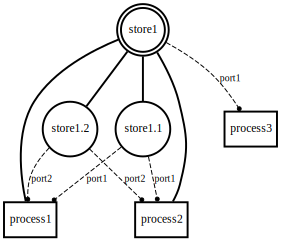

In [16]:
plot_bigraph(filled_instance)

## Update

## Query

Find a schema within a composite. For example find a mitochondria within a cell

## Adapters

Show how adapters can automatically compose into a schema to provide translation between types.